In [19]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

import keras.utils
from tensorflow.keras.models import Sequential
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Conv2DTranspose, Reshape, BatchNormalization, Dropout, Input, ReLU, LeakyReLU

# **MODEL**

In [20]:
# Tạo bộ khởi tạo trọng số ngẫu nhiên với phân phối chuẩn
KI = RandomNormal(mean=0.0, stddev=0.02)

# Định nghĩa kích thước đầu vào của noise (latent space vector)
input_dim = 256

# Hàm tạo Generator Model
def Generator_Model():
    Generator = Sequential()

    # Lớp đầu tiên: Nhận đầu vào là noise (vector 1D) và chuyển đổi thành một tensor 8x8x1024
    Generator.add(Dense(8 * 8 * 1024, input_dim=input_dim))  # Fully connected layer
    Generator.add(ReLU())  # Hàm kích hoạt ReLU để giới thiệu tính phi tuyến

    # Reshape tensor 1D thành tensor 3D có kích thước 8x8x1024 (chuẩn bị để upsample)
    Generator.add(Reshape((8, 8, 1024)))

    # Lớp Conv2DTranspose 1: Upsample tensor từ 8x8x1024 lên 16x16x512
    Generator.add(Conv2DTranspose(512, (4, 4), strides=(2, 2), padding='same',
                                  kernel_initializer=KI, activation='relu'))

    # Lớp Conv2DTranspose 2: Upsample tensor từ 16x16x512 lên 32x32x256
    Generator.add(Conv2DTranspose(256, (4, 4), strides=(2, 2), padding='same',
                                  kernel_initializer=KI, activation='relu'))

    # Lớp Conv2DTranspose 3: Upsample tensor từ 32x32x256 lên 64x64x128
    Generator.add(Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same',
                                  kernel_initializer=KI, activation='relu'))

    # Lớp đầu ra: Chuyển tensor 64x64x128 thành 64x64x3 (3 kênh RGB) và sử dụng sigmoid để đưa giá trị pixel về [0, 1]
    Generator.add(Conv2D(3, (4, 4), padding='same', activation='sigmoid'))

    return Generator  # Trả về mô hình generator


def Discriminator_Model():
    input_shape = (64, 64, 3)  # Đầu vào của mô hình: ảnh RGB kích thước 64x64x3

    # Tạo mô hình Sequential cho Discriminator
    discriminator = Sequential()

    # Lớp Conv2D 1: Trích xuất đặc trưng từ ảnh, sử dụng 64 kernel kích thước 3x3
    discriminator.add(Conv2D(64, kernel_size=(3, 3), input_shape=input_shape))  # Định nghĩa kích thước đầu vào
    discriminator.add(LeakyReLU(alpha=0.2))  # Hàm kích hoạt LeakyReLU (để tránh chết neuron)
    discriminator.add(MaxPooling2D(pool_size=(2, 2)))  # Lấy mẫu giảm chiều kích thước 1/2 (32x32x64)

    # Lớp Conv2D 2: Tăng số lượng kernel lên 128 để trích xuất đặc trưng sâu hơn
    discriminator.add(Conv2D(128, kernel_size=(3, 3)))
    discriminator.add(LeakyReLU(alpha=0.2))  # Thêm tính phi tuyến bằng LeakyReLU
    discriminator.add(MaxPooling2D(pool_size=(2, 2)))  # Lấy mẫu giảm chiều kích thước 1/2 (16x16x128)

    # Lớp Conv2D 3: Tăng số lượng kernel lên 256
    discriminator.add(Conv2D(256, kernel_size=(3, 3)))
    discriminator.add(LeakyReLU(alpha=0.2))
    discriminator.add(MaxPooling2D(pool_size=(2, 2)))  # Lấy mẫu giảm chiều kích thước 1/2 (8x8x256)

    # Lớp Flatten: Chuyển đổi tensor 3D (8x8x256) thành vector 1D để đưa vào Fully Connected Layer
    discriminator.add(Flatten())

    # Lớp Dense 1: Fully connected với 256 neuron
    discriminator.add(Dense(256))
    discriminator.add(LeakyReLU(alpha=0.2))  # Kích hoạt bằng LeakyReLU

    # Lớp Dense 2 (đầu ra): Chuyển đổi về giá trị xác suất (1 neuron, hàm kích hoạt sigmoid)
    discriminator.add(Dense(1, activation='sigmoid'))  # Dự đoán ảnh là thật (1) hoặc giả (0)

    return discriminator

class DCGAN(tf.keras.Model):
    def __init__(self, generator=None, discriminator=None, latent_dim=256, **kwargs):
        super().__init__(**kwargs)
        self.generator = generator
        self.discriminator = discriminator
        self.latent_dim = latent_dim

    def compile(self, g_optimizer, d_optimizer, loss_fn):
        super(DCGAN, self).compile()
        self.g_optimizer = g_optimizer
        self.d_optimizer = d_optimizer
        self.loss_fn = loss_fn

    def call(self, inputs):
        generated_images = self.generator(inputs)
        predictions = self.discriminator(generated_images)
        return predictions

    @classmethod
    def from_config(cls, config):
        config.pop('trainable', None)
        return cls(**config)


class DCGAN(keras.Model):
    def __init__(self, generator, discriminator, latent_dim=input_dim):
        super().__init__()
        self.generator = generator  # Mô hình Generator
        self.discriminator = discriminator  # Mô hình Discriminator
        self.latent_dim = latent_dim  # Kích thước vector noise đầu vào (latent space)
        self.g_loss_metric = keras.metrics.Mean(name='g_loss')  # Đo lường loss của Generator
        self.d_loss_metric = keras.metrics.Mean(name='d_loss')  # Đo lường loss của Discriminator

    @property
    def metrics(self):
        # Trả về các metric để theo dõi trong quá trình huấn luyện
        return [self.g_loss_metric, self.d_loss_metric]

    # Hàm khởi tạo trình biên dịch
    def compile(self, g_optimizer, d_optimizer, loss_fn):
        super(DCGAN, self).compile()
        self.g_optimizer = g_optimizer  # Optimizer cho Generator
        self.d_optimizer = d_optimizer  # Optimizer cho Discriminator
        self.loss_fn = loss_fn  # Hàm tính loss (binary cross-entropy)

    # Hàm thực hiện một bước huấn luyện (train_step)
    def train_step(self, real_images):
        # Lấy batch size từ dữ liệu đầu vào
        batch_size = tf.shape(real_images)[0]

        # Tạo noise ngẫu nhiên để đưa vào Generator
        random_noise = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Huấn luyện mô hình Discriminator với ảnh thật (1) và ảnh giả (0)
        with tf.GradientTape() as tape:
            # Tính dự đoán (predictions) trên ảnh thật
            pred_real = self.discriminator(real_images, training=True)
            # Tạo nhãn ảnh thật (giá trị gần 1), sử dụng label smoothing
            real_labels = tf.ones((batch_size, 1))
            real_labels += 0.05 * tf.random.uniform(tf.shape(real_labels))  # Thêm nhiễu nhẹ vào nhãn
            d_loss_real = self.loss_fn(real_labels, pred_real)  # Tính loss trên ảnh thật

            # Tạo ảnh giả từ Generator
            fake_images = self.generator(random_noise)
            # Tính dự đoán trên ảnh giả
            pred_fake = self.discriminator(fake_images, training=True)
            # Tạo nhãn ảnh giả (giá trị gần 0)
            fake_labels = tf.zeros((batch_size, 1))
            d_loss_fake = self.loss_fn(fake_labels, pred_fake)  # Tính loss trên ảnh giả

            # Tổng loss của Discriminator
            d_loss = (d_loss_real + d_loss_fake) / 2

        # Tính gradient của Discriminator
        gradients = tape.gradient(d_loss, self.discriminator.trainable_variables)
        # Cập nhật trọng số của Discriminator
        self.d_optimizer.apply_gradients(zip(gradients, self.discriminator.trainable_variables))

        # Huấn luyện mô hình Generator
        labels = tf.ones((batch_size, 1))  # Generator muốn Discriminator nghĩ rằng ảnh giả là thật
        with tf.GradientTape() as tape:
            # Tạo ảnh giả từ Generator
            fake_images = self.generator(random_noise, training=True)
            # Tính dự đoán của Discriminator trên ảnh giả
            pred_fake = self.discriminator(fake_images, training=True)
            # Tính loss của Generator (muốn Discriminator dự đoán nhãn là 1)
            g_loss = self.loss_fn(labels, pred_fake)

        # Tính gradient của Generator
        gradients = tape.gradient(g_loss, self.generator.trainable_variables)
        # Cập nhật trọng số của Generator
        self.g_optimizer.apply_gradients(zip(gradients, self.generator.trainable_variables))

        # Cập nhật trạng thái metric cho cả hai mô hình
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)

        # Trả về giá trị loss của Discriminator và Generator sau mỗi bước huấn luyện
        return {'d_loss': self.d_loss_metric.result(), 'g_loss': self.g_loss_metric.result()}

# **GEN ẢNH**

In [21]:
generator = Generator_Model()
discriminator = Discriminator_Model()
dcgan = DCGAN(generator=generator, discriminator=discriminator)

# Tải trọng số
dcgan.load_weights("/content/dcgan_epoch_100.h5")
print("Weights loaded successfully into the DCGAN model.")

Weights loaded successfully into the DCGAN model.


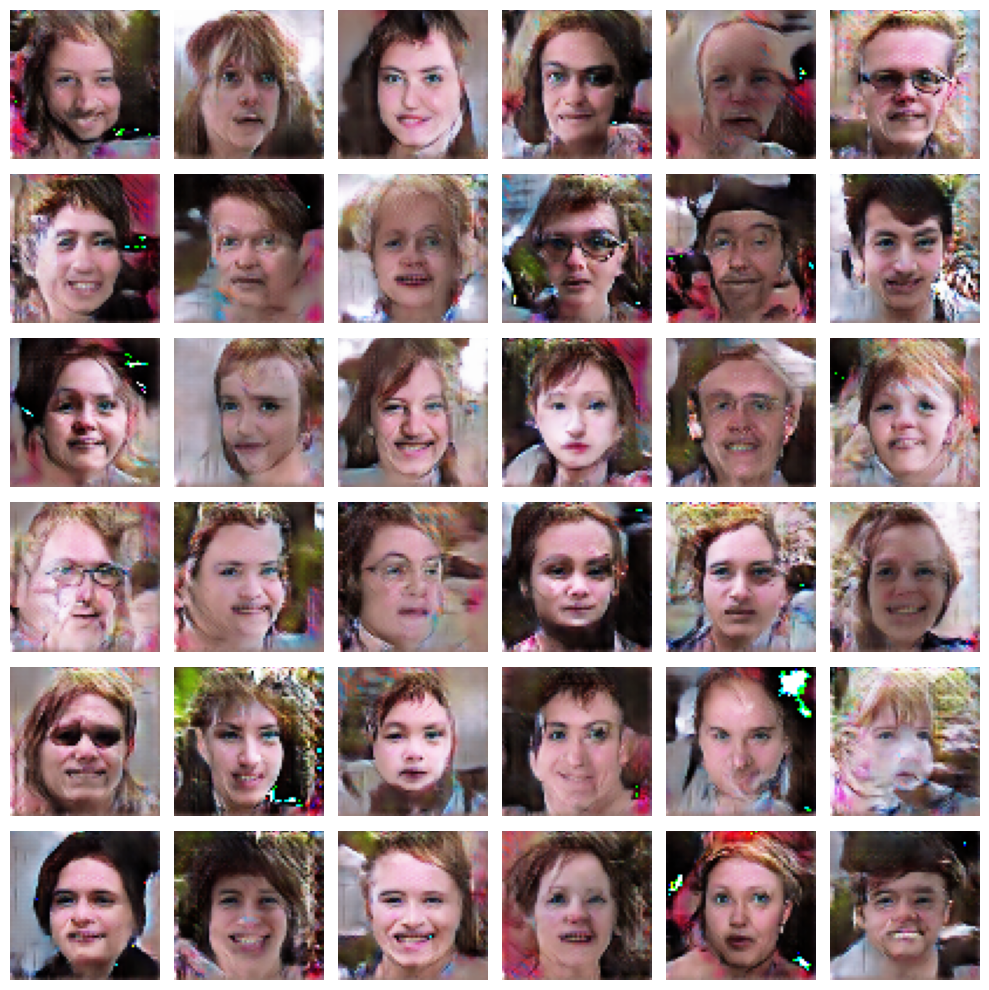

In [22]:
num_images = 36
plt.figure(figsize=(10, 10))

for i in range(num_images):
    plt.subplot(6, 6, i + 1)

    noise = tf.random.normal([1, 256])
    mg = dcgan.generator(noise)
    mg = (mg * 255) + 255
    mg.numpy()
    image = Image.fromarray(np.uint8(mg[0]))
    plt.imshow(image)
    plt.axis('off')

plt.tight_layout()
plt.show()